# 07 - Analyse Temporelle Univariée 

---

&nbsp;

## 1. Série Temporelle Brute

> #### Quel jeu de données choisir ?

Tout d'abord on sélectionne le jeu de données "sstCOPERNICUS20102019Processed" puisque ce dernier contient nos données groupées, ayant les mêmes unitées et sans NaN.

On ne prendra pas notre jeu de données désaisonnalisé puisque sinon il ne s'agira plus de données "brutes", le cycle annuel étant une réalité physique pas simplement un bruit.

&nbsp;

> #### Comment applique-t-on notre réduction dimensionelle ?

Nous partons d'un jeu de données comme : $SST(t,lat,lon)$.

Et puisque nous souhaitons une analyse temporelle univariée on souhaite arriver à $SST(t)$.

Ainsi on réalisera une moyenne spatiale puisqu'elle permet de transformer notre champ 3D en une série 1D. De plus elle permet de représenter l'état thermique moyen de la température à la surface de la Manche.

Minimum = 6.613592624664307
Maximum = 18.623645782470703
Amplitude = 12.010053634643555


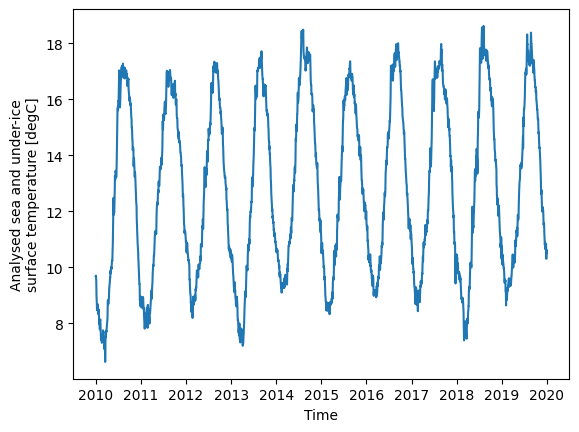

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

dataset = xr.open_dataset("../../data/processed/sstCOPERNICUS20102019Processed.nc")

sst = dataset["analysed_sst"]

sstTemporelUnivariee = sst.mean(dim=["latitude","longitude"])
sstTemporelUnivariee.plot()
plt.show

print("Minimum =", float(sstTemporelUnivariee.min()))
print("Maximum =", float(sstTemporelUnivariee.max()))
print("Amplitude =", float(sstTemporelUnivariee.max() - sstTemporelUnivariee.min()))


&nbsp;

> #### Que peut-on expliquer à partir de notre courbe ?

On sait que maintenant on a SST(t), ce qui concrètement correspond à une valeur par jour en °C et à la moyenne spatiale sur toute notre zone : il s'agit d'une série temporelle univariée climatique.

Nos valeurs varient de 6.6°C à 18.6°C donc notre amplitude est de 12°C ce qui est cohérent physiquement pour une moyenne régionale avec un cycle saisonnier important.
Notre minimum correspondra à l'hiver le plus froid sur notre période et notre maximum à l'été le plus chaud.

On peut aussi observer des oscillations régulières d'une période d'environ 1 an qui montrent un cycle annuel très présent.

Certaines de nos années sont globalement plus chaudes ou plus froides puisque nos pics ne sont pas tous exactement à la même hauteur, cette variabilité est réelle et masquée en partie par la saisonnalité.

&nbsp;


---

&nbsp;

## 2. Moyenne mobile

> #### Quelle période de temps choisir pour notre moyenne mobile ?

Pour obtenir une moyenne mobile exploitable et pouvoir mettre en évidence une potentielle tendance nous devons réduire l'impact de la saisonnalité qui est dominante sur nos données ainsi on choisira une fenêtre de 365 jours puisque la saisonnalité se fait sur une période d'1 an.

On ne retire pas totalement la saisonnalité afin de garder un jeu de données brut et de garder un lien direct avec notre signal observé.

&nbsp;

> #### Quelle formule utiliserons nous ?

Nous utiliserons la formule générale suivante :
$$
\overline{SST_{k}}(t) = \frac{1}{k} \sum_{i = t - \frac{k}{2}}^{t + \frac{k}{2}} SST(i)
$$
où:
- $k$ : la taille de la fenêtre en jours.

<xarray.DataArray 'analysed_sst' (time: 3652)> Size: 15kB
array([       nan,        nan,        nan, ..., 13.114368 , 13.115247 ,
       13.1158285], shape=(3652,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
Attributes:
    units:          degC
    standard_name:  sea_surface_temperature
    long_name:      Analysed sea and under-ice surface temperature
    comment:        The under-ice SST is the freezing point temperature TS, c...
    source:         AASTI v2 SST/IST, ESA CCI SST and C3S SST L2P products
    valid_range:    [-6000  4500]


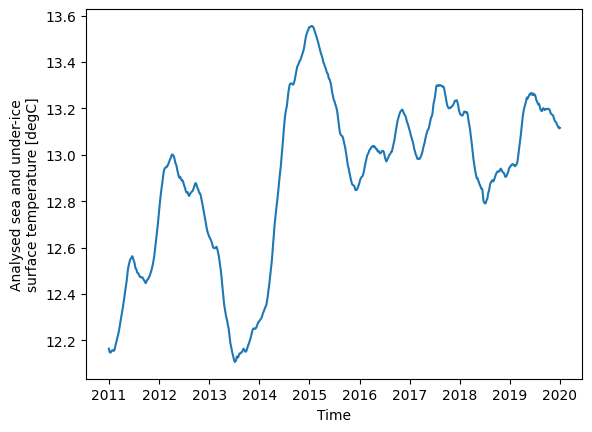

Ecart-type brut = 3.1717424392700195
Ecart-type moyenne mobile = 0.3631448447704315


In [2]:
sstMoyenneMobile = sstTemporelUnivariee.rolling(time=365).mean()
sstMoyenneMobile.plot()
print(sstMoyenneMobile)
plt.show()
print("Ecart-type brut =", float(sstTemporelUnivariee.std()))
print("Ecart-type moyenne mobile =", float(sstMoyenneMobile.std()))


> #### Comment exploiter notre courbe ?

Tout d'abord on peut remarquer que notre courbe est beaucoup plus lisse notamment puisque nos oscillations saisonnières ont disparus. De plus nos variations se font au niveau pluriannuelle. On observe une évolution lente de la SST moyenne sur la période. Enfin  notre écart-type brut est d'environ 3.17°C tandis que l'écart-type de notre moyenne mobile est d'environ 0.36°C ainsi on peut justifier la différence de dispersion de nos données sur nos courbes.

Pour conclure, la forte saisonnalité masque en partie les variations de plus longue période. Le lissage par moyenne mobile peremt de réduire la variabilité et montrer l'évolution de la SST moyenne sur notre période.

&nbsp;

---

&nbsp;


## 3. Décomposition saisonnière

> #### Qu'est-ce que la décomposition saisonnière et pourquoi l'utilise t'on ?

La décomposition saisonnière est une méthode d'analyse de série temporelle qui permet de séparer les différentes composantes du signal : la tendance de fond, la saisonnalité et les résidus. Elle est particulièrement adaptée pour une série avec une saisonnalité marquée comme dans le cas de la température à la surface de la Manche. 

On utilisera donc nos données brutes afin de conserver l'intégralité du signal observé.

Une analyse temporelle est ici pertinente puisqu'on sait que notre saisonnalisation s'effectue sur un cycle annuel et qu'on sait qu'elle est dominante.

&nbsp;

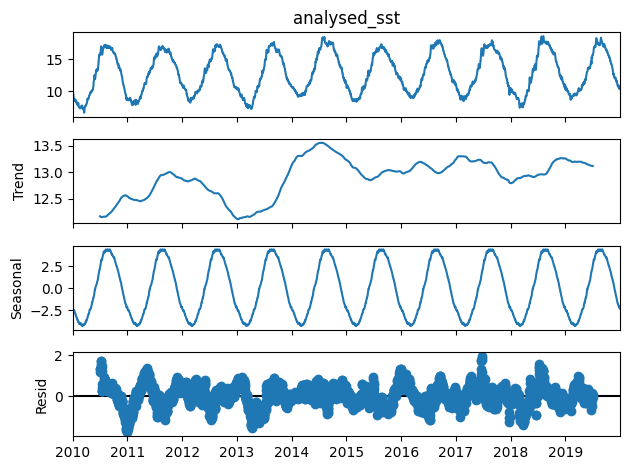

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

sstPandas = sstTemporelUnivariee.to_pandas()

decomposition = seasonal_decompose(
    sstPandas,
    model="additive",
    period=365
)

decomposition.plot()
plt.show()

&nbsp;

> #### Que visualise t'on ?

Tout d'abord notre première courbe représente la série observée qui contient l'ensemble des composantes du signal.

La deuxième courbe elle représente la tendance, elle a un écart-type d'environ 0.36°C et une variation totale d'environ 1.45°C sur la période étudiée. Ainsi notre tendance est à faible amplitude comparée à notre saisonnalité mais reste non négligeable à l'échelle de la décennie.

Notre troisième courbe représente la composante saisonnière, elle a une moyenne de 0 ce qui est normal, un écart-type d'environ 3.06°C et une amplitude totale d'environ 8.78°C. On peut donc en conclure que notre composante saisonnière est bien  dominante pour la variabilité du signal et qu'elle correspond bien à un cycle annuel régulier ce qui est cohérent avec le forçage saisonnier.

Enfin notre dernière courbe représente les résidus, son écart-type est d'environ 0.51°C avec un centrage autour de 0. Nos résidus correspondent à la variabilité interannuelle et aux anomalies non expliquées par la tendance ou la saisonnalité .De plus si on effectue le ratio écart-type résidu sur écart-type brut on obtient environ 0.16 ce qui signifie que 84% de la variabilité initiale est expliquée par la saisonnalité et la tendance et donc que seulement 16% viennent du bruit et des anomalies. Cela nous permet de confirmet que le modèle est bien additif, le forçage saisonnier domine et l'évolution de fond joue un rôle plus secondaire.

&nbsp;

---

&nbsp;

## 4. Tendance linéaire

>#### Pourquoi faisons nous une tendance linéaire ?

La tendance linéaire sert à quantifier l'évolution lente que nous avons observé avec la moyenne mobile et fournir un chiffre simple en °C/an afin de pouvoir comparer avec d'autres régions ou d'autres études.

>#### Quel jeu de données allons-nous utiliser ?

On utilisera notre composante de tendance trouvé grâce à notre décomposition saisonnière puisque la saisonnalité est déjà retirée et le bruit est fortement réduit.

Pente de la tendance =  0.08245024460290933 °C/an


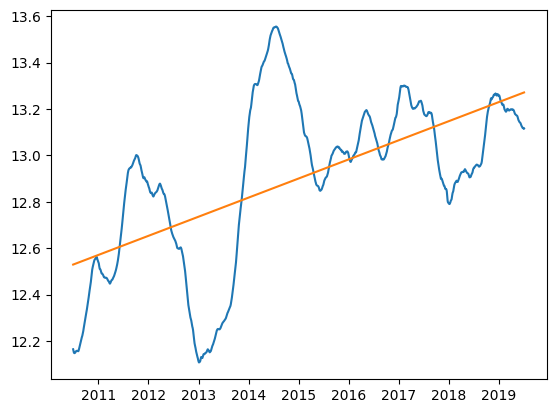

In [4]:
import numpy as np

trend = decomposition.trend.dropna()
time_years = (trend.index - trend.index[0]).days / 365.25
coeffs = np.polyfit(time_years, trend.values, 1)
slope = coeffs[0]
intercept = coeffs[1]
print("Pente de la tendance = ", slope, "°C/an")
trend_fit = slope * time_years + intercept
plt.figure()
plt.plot(trend.index,trend.values, label="Tendance extraite")
plt.plot(trend.index, trend_fit, label="Tendance linéaire")
plt.show()

&nbsp;

>#### Comment interpréter nos résultats ?

La courbe bleue de notre schéma représente la courbe de tendance issue de la décomposition saisonnière donc sans saisonnalité.
La courbe orange elle représente l'ajustement linéaire sur cette tendance.

On peut donc voir que notre évolution globale est croissante sur la période 2010-2019 avec des fluctuations pluriannuelles (pics vers 2014-2015 et creux en 2013 et 2018).
La droite ne force pas notre signal, elle capture bien l'évolution moyenne. Ainsi visuellement notre régression est pertinente comme approximation de fond.

Pour notre pente on obtient environ 0.082°C/an ce qui correspond à 0.82°C par décennie pour une période de 10 ans ce qui est cohérent avec une variation totale de la tendance et ce que montrait la décomposition puisqu'on observait une variation totale de l'ordre de 1 à 1.5°C. De plus ce résultat est également cohérent avec la moyenne mobile puisqu'on observait une courbe lissée avec une évolution lente et un niveau plus élevé en fin de période par rapport au début de la période.

Ainsi on peut conclure que nous observons une augmentation moyenne sur la période étudiée, en approximation linéaire et qui est locale donc une tendance positive marquée.

&nbsp;

---

&nbsp;

## 5. Variabilité interannuelle

>#### Qu'est-ce que la variabilité interannuelle ?

La variabilité interannuelle correspond aux variations d'une année à l'autre qui ne sont pas expliquées par la saisonnalité annuelle ou par la tendance de fond.

Il s'agit donc de ce qui reste après avoir retiré le cycle saisonnier et l'évolution lente de long terme c'est à dire les anomalies climatiques et les évènements locaux naturels.

&nbsp;

>#### Quel jeu de données choisit-on ?

On sélectionne les résidus issus de la décomposition saisonnière puisque la saisonnalité est retirée ainsi que la tendance. Ainsi il ne reste que la variabilité non expliquée.

&nbsp;

>#### Que souhaitons-nous expliquer ?
On cherche à quantifier l'amplitude de la variabilité interannuelle, comparer son importance par rapport aux autres composantes et identifier d'éventuelles années atypiques.

&nbsp;

Moyenne résidus = 0.008557374486901591
Écart-type résidus = 0.5149400955674575
Amplitude typique (q95-q05) = 1.6854213648771443
time
2010-12-31    0.068756
2011-12-31    0.031102
2012-12-31    0.032272
2013-12-31   -0.111444
2014-12-31    0.155590
2015-12-31   -0.116860
2016-12-31    0.028233
2017-12-31    0.045497
2018-12-31   -0.058756
2019-12-31    0.073430
Freq: YE-DEC, Name: resid, dtype: float64
time
2010-12-31    0.705317
2011-12-31    0.658992
2012-12-31    0.381656
2013-12-31    0.614648
2014-12-31    0.294068
2015-12-31    0.439966
2016-12-31    0.494796
2017-12-31    0.470322
2018-12-31    0.565861
2019-12-31    0.339048
Freq: YE-DEC, Name: resid, dtype: float64


C:\Users\gaoks\AppData\Local\Temp\ipykernel_22716\106625395.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  resid_annual_mean = resid.resample("Y").mean()
C:\Users\gaoks\AppData\Local\Temp\ipykernel_22716\106625395.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  resid_annual_std = resid.resample("Y").std()


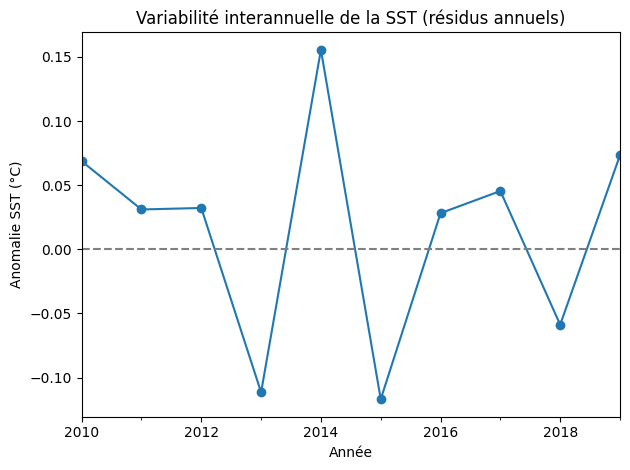

In [6]:
resid = decomposition.resid.dropna()
print("Moyenne résidus =", float(resid.mean()))
print("Écart-type résidus =", float(resid.std()))
print("Amplitude typique (q95-q05) =", float(resid.quantile(0.95) - resid.quantile(0.05)))
residAnnualMean = resid.resample("Y").mean()
residAnnualStd = resid.resample("Y").std()
print(residAnnualMean)
print(residAnnualStd)

plt.figure()
residAnnualMean.plot(marker="o")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Variabilité interannuelle de la SST (résidus annuels)")
plt.xlabel("Année")
plt.ylabel("Anomalie SST (°C)")
plt.tight_layout()
plt.show()
